In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

sys.path.append(os.path.abspath('../..'))
from models import LogisticRegression, LogisticRegressionUndersampling, LogisticRegressionOversampling, LogisticRegressionSmote
from metrics import ClassificationMetrics
from data_splitting import train_val_split, cross_val
df = pd.read_csv('/home/facuvulcano/Machine-Learning/Vulcano_Facundo_TP3/Problema_1/data/raw/breast_cancer_dev.csv')

## **Regresion logistica con regularizacion L2 sin utilizar ningun metodo de balanceo para equilibrar el dataset. Se utiliza cross-validation para entrenar el modelo y la metrica f-score para hallar el hiperparametro de lambda que maximiza su resultado.**

Average f-scores: {0: 0.6241222175582751, 0.0001: 0.6358892907051689, 0.001: 0.6250868690230462, 0.01: 0.6302464016139926, 0.1: 0.631595878867104, 1: 0.625845015231914, 10: 0.29991846261077515, 100: 0.009084156566664307}
The best lambda is 0.0001 with an average f2-score of 0.6359


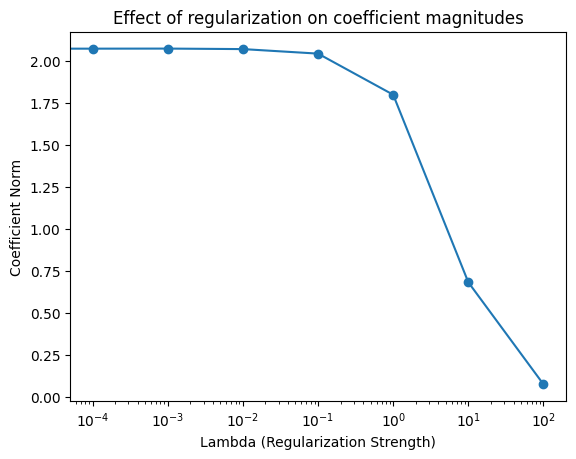

In [3]:
MAX_ITER = 100
lambdas = [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
global_results = {lambda_ : 0 for lambda_ in lambdas}
coef_norm_avg = {lambda_ : 0 for lambda_ in lambdas}
n_folds = 5

for iter in range(MAX_ITER):
    for lambda_ in lambdas:
        reg_without_balancing = LogisticRegression(
            threshold=0.246, max_iter=1000, learning_rate=0.1, lambda_penalty=lambda_
            )
        
        #data splitting
        training, validation = cross_val(df, 'target', n_folds)

        fold_f_scores = []
        fold_coef_norms = []
        y_val_cv_lru = []
        y_val_cv_pred_lru = []

        for (train, val) in zip(training, validation):
            X_train_cv, y_train_cv = train[0], train[1].to_numpy()
            X_val_cv, y_val_cv = val[0], val[1].to_numpy()

            #model training
            reg_without_balancing.fit(X_train_cv, y_train_cv)

            #predicitons on validation data
            y_pred_val_cv = reg_without_balancing.predict(X_val_cv)
            predicted_probabilites_val_cv = reg_without_balancing.predict_proba(X_val_cv)

            y_val_cv_lru.append(y_val_cv)
            y_val_cv_pred_lru.append(y_pred_val_cv)

            #calculation of f-score metric
            metrics = ClassificationMetrics(y_val_cv, y_pred_val_cv, predicted_probabilites_val_cv)
            f_score = metrics.f_score()
            fold_f_scores.append(f_score)

            coef_norm = np.linalg.norm(reg_without_balancing.coef_)
            fold_coef_norms.append(coef_norm)

        avg_f2_score = np.mean(fold_f_scores)
        avg_coef_norm = np.mean(fold_coef_norms)

        global_results[lambda_] += avg_f2_score
        coef_norm_avg[lambda_] += avg_coef_norm


for lambda_ in global_results:
    global_results[lambda_] /= MAX_ITER
    coef_norm_avg[lambda_] /= MAX_ITER

print(f'Average f-scores: {global_results}')
best_lambda = max(global_results, key=global_results.get)
print(f'The best lambda is {best_lambda} with an average f2-score of {global_results[best_lambda]:.4f}')

plt.plot(list(coef_norm_avg.keys()), list(coef_norm_avg.values()), marker = 'o')
plt.xscale('log')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Coefficient Norm')
plt.title('Effect of regularization on coefficient magnitudes')
plt.show()

### **Explicacion**:

Se puede concluir mirando los resultados que un lambda de regularizacion con valores alrededor de 0.01 presenta un buen balance entre precision y recall. Es el punto en el que la regularizacion es fuerte como para evitar el overfitting pero no tan fuerte como para causar underfitting.

## **Regresion Logistica con regularizacion L2 utilizando undersampling imbalance (eliminacion aleatoria de muestras de la clase mayoritaria) para balancear el dataset. Se utiliza cross-validation para entenar el modelo y la metrica f-score para elegir el mejor lambda de regularizacion.**

Average f-scores: {0: 0.7689791687339265, 0.0001: 0.7643913418655172, 0.001: 0.7664543210444367, 0.01: 0.7643896282736072, 0.1: 0.7654136558558134, 1: 0.7545228132853039, 10: 0.5565458055656288, 100: 0.36854530911501976}
The best lambda is 0 with an average f2-score of 0.7690


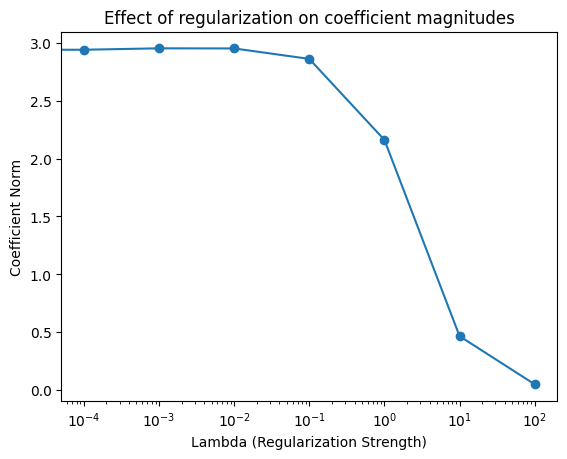

In [9]:
MAX_ITER = 100
lambdas = [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
global_results = {lambda_ : 0 for lambda_ in lambdas}
coef_norm_avg = {lambda_ : 0 for lambda_ in lambdas}
n_folds = 5

for iter in range(MAX_ITER):
    for lambda_ in lambdas:
        reg_with_undersampling = LogisticRegressionUndersampling(
            df, threshold=0.5, max_iter=1000, learning_rate=0.1, lambda_penalty=lambda_
            )
        
        #undersampling and data splitting
        balanced_df = reg_with_undersampling.undersampling()
        training, validation = cross_val(balanced_df, 'target', n_folds)

        fold_f_scores = []
        fold_coef_norms = []
        y_val_cv_lru = []
        y_val_cv_pred_lru = []

        for (train, val) in zip(training, validation):
            X_train_cv, y_train_cv = train[0], train[1].to_numpy()
            X_val_cv, y_val_cv = val[0], val[1].to_numpy()

            #model training
            reg_with_undersampling.fit(X_train_cv, y_train_cv)

            #predicitons on validation data
            y_pred_val_cv = reg_with_undersampling.predict(X_val_cv)
            predicted_probabilites_val_cv = reg_with_undersampling.predict_proba(X_val_cv)

            y_val_cv_lru.append(y_val_cv)
            y_val_cv_pred_lru.append(y_pred_val_cv)

            #calculation of f2 metric
            metrics = ClassificationMetrics(y_val_cv, y_pred_val_cv, predicted_probabilites_val_cv)
            f2_score = metrics.f_score()
            fold_f_scores.append(f2_score)

            coef_norm = np.linalg.norm(reg_with_undersampling.coef_)
            fold_coef_norms.append(coef_norm)

        avg_f2_score = np.mean(fold_f_scores)
        avg_coef_norm = np.mean(fold_coef_norms)

        global_results[lambda_] += avg_f2_score
        coef_norm_avg[lambda_] += avg_coef_norm


for lambda_ in global_results:
    global_results[lambda_] /= MAX_ITER
    coef_norm_avg[lambda_] /= MAX_ITER

print(f'Average f-scores: {global_results}')
best_lambda = max(global_results, key=global_results.get)
print(f'The best lambda is {best_lambda} with an average f2-score of {global_results[best_lambda]:.4f}')

plt.plot(list(coef_norm_avg.keys()), list(coef_norm_avg.values()), marker = 'o')
plt.xscale('log')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Coefficient Norm')
plt.title('Effect of regularization on coefficient magnitudes')
plt.show()

### **Explicacion**

Se puede observar en los resultados que a medida que el valor de lambda incrementa la regularizacion se vuelve mas fuerte, reduciendo asi la magnitud de los coeficientes, lo que limita la expresividad y complejidad del modelo. Los lambdas mas chicos mantienen magnitudes de los coeficientes mas altos y ademas obtienen un mejor f-score. Se puede determinar con los resultados que una minima regularizacion es suficiente para obtener un buen balance entre precision y recall.

## **Regresion logistica con oversampling por duplicacion (duplicacion aleatoria de muestras de la clase minoritaria) utilizando regularizacion L2. Se entrena el modelo utilizando el metodo de cross-validation y se utiliza la metrica f-score para hallar el mejor lambda de regularizacion**

Average f-scores: {0: 0.7897217613137428, 0.0001: 0.7905122720708535, 0.001: 0.7810777162083962, 0.01: 0.7842252276207939, 0.1: 0.7879086967066005, 1: 0.7822720092307168, 10: 0.7710485165957719, 100: 0.5048715061564979}
The best lambda is 0.0001 with an average f2-score of 0.7905


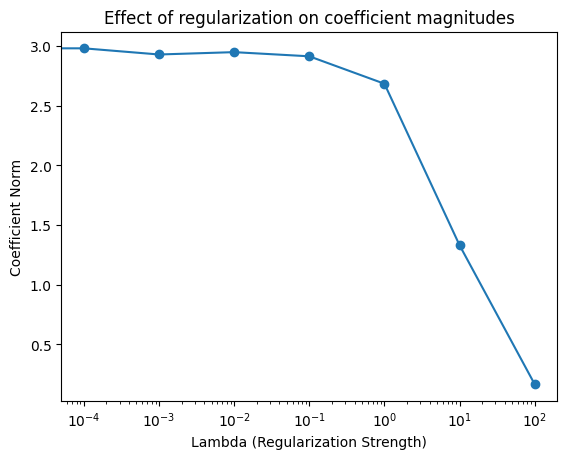

In [2]:
MAX_ITER = 100
lambdas = [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
global_results = {lambda_ : 0 for lambda_ in lambdas}
coef_norm_avg = {lambda_ : 0 for lambda_ in lambdas}
n_folds = 5

for iter in range(MAX_ITER):
    for lambda_ in lambdas:
        reg_with_oversampling = LogisticRegressionOversampling(
            df, threshold=0.5, max_iter=1000, learning_rate=0.1, lambda_penalty=lambda_
            )
        
        #undersampling and data splitting
        balanced_df = reg_with_oversampling.oversampling()
        training, validation = cross_val(balanced_df, 'target', n_folds)

        fold_f_scores = []
        fold_coef_norms = []
        y_val_cv_lru = []
        y_val_cv_pred_lru = []

        for (train, val) in zip(training, validation):
            X_train_cv, y_train_cv = train[0], train[1].to_numpy()
            X_val_cv, y_val_cv = val[0], val[1].to_numpy()

            #model training
            reg_with_oversampling.fit(X_train_cv, y_train_cv)

            #predicitons on validation data
            y_pred_val_cv = reg_with_oversampling.predict(X_val_cv)
            predicted_probabilites_val_cv = reg_with_oversampling.predict_proba(X_val_cv)

            y_val_cv_lru.append(y_val_cv)
            y_val_cv_pred_lru.append(y_pred_val_cv)

            #calculation of f-score metric
            metrics = ClassificationMetrics(y_val_cv, y_pred_val_cv, predicted_probabilites_val_cv)
            f2_score = metrics.f_score()
            fold_f_scores.append(f2_score)

            coef_norm = np.linalg.norm(reg_with_oversampling.coef_)
            fold_coef_norms.append(coef_norm)

        avg_f2_score = np.mean(fold_f_scores)
        avg_coef_norm = np.mean(fold_coef_norms)

        global_results[lambda_] += avg_f2_score
        coef_norm_avg[lambda_] += avg_coef_norm


for lambda_ in global_results:
    global_results[lambda_] /= MAX_ITER
    coef_norm_avg[lambda_] /= MAX_ITER

print(f'Average f-scores: {global_results}')
best_lambda = max(global_results, key=global_results.get)
print(f'The best lambda is {best_lambda} with an average f2-score of {global_results[best_lambda]:.4f}')

plt.plot(list(coef_norm_avg.keys()), list(coef_norm_avg.values()), marker = 'o')
plt.xscale('log')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Coefficient Norm')
plt.title('Effect of regularization on coefficient magnitudes')
plt.show()

## **Logistic Regression with SMOTE oversampling: generates synthetic samples from minority class until both have the same proportion**

In [2]:
MAX_ITER = 100
lambdas = [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
global_results = {lambda_ : 0 for lambda_ in lambdas}
coef_norm_avg = {lambda_ : 0 for lambda_ in lambdas}
n_folds = 5

for iter in range(MAX_ITER):
    for lambda_ in lambdas:
        reg_with_smote = LogisticRegressionSmote(
            df, threshold=0.5, max_iter=1000, learning_rate=0.1, lambda_penalty=lambda_
            )
        
        #undersampling and data splitting
        balanced_df = reg_with_smote.smote()
        training, validation = cross_val(balanced_df, 'target', n_folds)

        fold_f_scores = []
        fold_coef_norms = []
        y_val_cv_lru = []
        y_val_cv_pred_lru = []

        for (train, val) in zip(training, validation):
            X_train_cv, y_train_cv = train[0], train[1].to_numpy()
            X_val_cv, y_val_cv = val[0], val[1].to_numpy()

            #model training
            reg_with_smote.fit(X_train_cv, y_train_cv)

            #predicitons on validation data
            y_pred_val_cv = reg_with_smote.predict(X_val_cv)
            predicted_probabilites_val_cv = reg_with_smote.predict_proba(X_val_cv)

            y_val_cv_lru.append(y_val_cv)
            y_val_cv_pred_lru.append(y_pred_val_cv)

            #calculation of f-score metric
            metrics = ClassificationMetrics(y_val_cv, y_pred_val_cv, predicted_probabilites_val_cv)
            f2_score = metrics.f_score()
            fold_f_scores.append(f2_score)

            coef_norm = np.linalg.norm(reg_with_smote.coef_)
            fold_coef_norms.append(coef_norm)

        avg_f2_score = np.mean(fold_f_scores)
        avg_coef_norm = np.mean(fold_coef_norms)

        global_results[lambda_] += avg_f2_score
        coef_norm_avg[lambda_] += avg_coef_norm


for lambda_ in global_results:
    global_results[lambda_] /= MAX_ITER
    coef_norm_avg[lambda_] /= MAX_ITER

print(f'Average f-scores: {global_results}')
best_lambda = max(global_results, key=global_results.get)
print(f'The best lambda is {best_lambda} with an average f2-score of {global_results[best_lambda]:.4f}')

plt.plot(list(coef_norm_avg.keys()), list(coef_norm_avg.values()), marker = 'o')
plt.xscale('log')
plt.xlabel('Lambda (Regularization Strength)')
plt.ylabel('Coefficient Norm')
plt.title('Effect of regularization on coefficient magnitudes')
plt.show()

KeyboardInterrupt: 

In [2]:
reg_with_smote = LogisticRegressionSmote(df, threshold=0.5, max_iter=1000, learning_rate=0.01, lambda_penalty=0.01)
balanced_df = reg_with_smote.smote()
class0 = balanced_df[balanced_df['target'] == 0]['target']
class1 = balanced_df[balanced_df['target'] == 1]['target']
print(class0)
print(class1)

1      0.0
2      0.0
3      0.0
5      0.0
6      0.0
      ... 
383    0.0
384    0.0
385    0.0
386    0.0
387    0.0
Name: target, Length: 302, dtype: float64
0      1.0
4      1.0
7      1.0
8      1.0
14     1.0
      ... 
599    1.0
600    1.0
601    1.0
602    1.0
603    1.0
Name: target, Length: 302, dtype: float64


In [14]:
#Creates synthethic samples for the minority class untill the proportion is the same as the majority class
# gets a sample from the minority class and calculates k=5 (for example) nearest neighbors.
# it then calculates the interpolation of the new sample. with the formula: x_new = x_original + lambda * (x_neighbour - x_original)

#k-nearest neighbors
#we get the euclidian distance from point i to all the other samples.
#We keep the k samples with smallest euclidian distance.


# Sample DataFrame (replace this with your actual dataset)


# import random

# class KNerestNeighbors:
#     def __init__(self, k, df, class1_idxs) -> None:
#         self.k = k
#         self.df = df
#         self.class1_idxs = class1_idxs

#     def _euclidian_distance(self, row1, row2):
#         return np.sqrt(np.sum((row1 - row2) ** 2))

#     def calculate_k_nearest(self):
#         distances_dict = {}
#         for i in range(len(self.class1_idxs)):

#             distances = []
#             for j in range(len(self.class1_idxs)):
#                 if i != j:
#                     dist = self._euclidian_distance(self.df.iloc[self.class1_idxs[i]], self.df.iloc[self.class1_idxs[j]])
#                     distances.append((dist, self.class1_idxs[j]))
                    
#             distances.sort()
#             distances_dict[self.class1_idxs[i]] = distances[:self.k]       
#         return distances_dict

# # Inicialization and neighbour calculation
# knn = KNerestNeighbors(k=5, df=df, class1_idxs=class1_idxs)
# k_nearest_distances = knn.calculate_k_nearest()
# # imbalance between clases
# diff = len(class0) - len(class1)
# new_rows = []
# # Counter to ciclic iterate throw the class1_idxs
# index_counter = 0
# #Create new rows until dataset is balanced
# while len(new_rows) < diff:
#     #get index ciclcly
#     key = class1_idxs[index_counter % len(class1_idxs)]
#     #get x_original based on the key
#     x_original = df.iloc[key]
#     #get a random neighbour from the k nearer
#     value = k_nearest_distances[key]
#     random_neighbour_index = random.choice(value)[1]
#     x_neighbour =  df.iloc[random_neighbour_index]


#     lamb = np.random.uniform(0, 1)

#     new_row = x_original + lamb * (x_neighbour - x_original)
#     new_rows.append(new_row)

#     index_counter += 1


{0: [(0.055444794183309824, 169), (0.05626013103546007, 270), (0.06320975033768471, 54), (0.07426021259617163, 262), (0.08647294226990418, 237)], 4: [(0.07064682707159745, 381), (0.12046070435105206, 26), (0.1226885911167266, 146), (0.12308715134800191, 220), (0.14169778334911046, 318)], 7: [(0.06283111739550216, 176), (0.07145212301086601, 237), (0.09171945753666981, 158), (0.1085646416409678, 369), (0.11286888157143807, 349)], 8: [(0.061188800997155915, 84), (0.06404837053463333, 186), (0.06408336254504371, 14), (0.06498715525902413, 275), (0.066496147556151, 211)], 14: [(0.02450923974552526, 211), (0.06408336254504371, 8), (0.07415662606239984, 84), (0.07724741843500496, 289), (0.08535378527051746, 335)], 17: [(0.08346220680867848, 100), (0.11615705025291433, 171), (0.11639899276546081, 353), (0.11659462966710157, 335), (0.117658619239518, 146)], 18: [(0.07519653054157928, 173), (0.09745258820312072, 220), (0.12047954010536056, 169), (0.12068068092011901, 0), (0.1257593973631509, 26